In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

# Sample Data

In [2]:
# load dataset (50,000 datapoints)
test_data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')
test_data = test_data.iloc[: , 1:]

In [3]:
# drop all cancelled and diverted flights
filter1 = (test_data['cancelled']!=1) & (test_data['diverted']!=1)
test_data = test_data[filter1]

# drop outliers
test_data = test_data[(test_data['arr_delay']<50) & (test_data['arr_delay']>-50)]
test_data = test_data[(test_data['dep_delay']<50) & (test_data['dep_delay']>-50)]

#Adding date time features and state
test_data['month'] = pd.DatetimeIndex(test_data['fl_date']).month
test_data['year'] = pd.DatetimeIndex(test_data['fl_date']).year
test_data['day'] = pd.DatetimeIndex(test_data['fl_date']).day
test_data['origin_city_state'] = test_data['origin_city_name'].transform(lambda x: str(x).split(',')[1])
test_data['origin_city'] = test_data['origin_city_name'].transform(lambda x: str(x).split(',')[0])
test_data['dest_city_state'] = test_data['dest_city_name'].transform(lambda x: str(x).split(',')[1])
test_data['dest_city'] = test_data['dest_city_name'].transform(lambda x: str(x).split(',')[0])
test_data['depart_hour'] = test_data['dep_time'].round(-2)

# Add key features
test_data['Route'] = test_data['origin_city'] + ' to ' + test_data['dest_city']

test_data['dep_delay_route'] = test_data[['dep_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
test_data['arr_delay_route'] = test_data[['arr_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
test_data['taxi_out_route'] = test_data[['taxi_out','Route']].groupby(by='Route').transform(lambda x: x.mean())
test_data['taxi_in_route'] = test_data[['taxi_in','Route']].groupby(by='Route').transform(lambda x: x.mean())

test_data['dep_delay_city'] = test_data[['dep_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
test_data['arr_delay_city'] = test_data[['arr_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
test_data['taxi_out_city'] = test_data[['taxi_out','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
test_data['taxi_in_city'] = test_data[['taxi_in','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())

test_data['dep_delay_month'] = test_data[['dep_delay','month']].groupby(by='month').transform(lambda x: x.mean())
test_data['arr_delay_month'] = test_data[['arr_delay','month']].groupby(by='month').transform(lambda x: x.mean())
test_data['taxi_out_month'] = test_data[['taxi_out','month']].groupby(by='month').transform(lambda x: x.mean())
test_data['taxi_in_month'] = test_data[['taxi_in','month']].groupby(by='month').transform(lambda x: x.mean())

#test_data['air_time'] = test_data[['air_time','Route']].groupby(by='Route').transform(lambda x: x.mean())


#drop columns
test_data = test_data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month','taxi_out','taxi_in','dep_delay','arr_delay']]

In [4]:
#create mean tables for merging later
route_table = test_data[['dep_delay','arr_delay','taxi_out','taxi_in','Route']].groupby(by='Route').mean()
origin_city_table = test_data[['dep_delay','arr_delay','taxi_out','taxi_in','origin_city']].groupby(by='origin_city').mean()
month_table = test_data[['dep_delay','arr_delay','taxi_out','taxi_in','month']].groupby(by='month').mean()
#air_time_table = test_data[['air_time','Route']].groupby(by='Route').mean()

In [5]:
#drop null values
test_data = test_data.dropna()
test_data.drop_duplicates()

# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
test_data['origin_city_state'] = test_data['origin_city_state'].astype('category')
test_data['origin_city'] = test_data['origin_city'].astype('category')
test_data['dest_city_state'] = test_data['dest_city_state'].astype('category')
test_data['dest_city'] = test_data['dest_city'].astype('category')
test_data['Route'] = test_data['Route'].astype('category')

test_data['origin_city_state'] = test_data['origin_city_state'].cat.codes
test_data['origin_city'] = test_data['origin_city'].cat.codes
test_data['dest_city_state'] = test_data['dest_city_state'].cat.codes
test_data['dest_city'] = test_data['dest_city'].cat.codes
test_data['Route'] = test_data['Route'].cat.codes

In [6]:
#Assign train and target variables
X = test_data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']]
y = test_data['arr_delay']

# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

#Create a Gaussian Classifier
model = make_pipeline(PolynomialFeatures(2),LinearRegression())

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Poly_regression_final.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 0.225
R2 Score2 for test data: 0.222
MAE Score for test data:  10.49


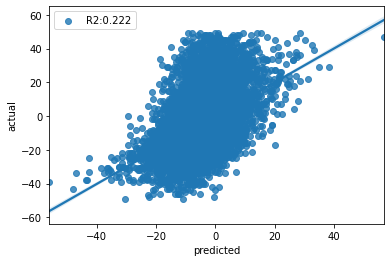

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

# Real Data

In [19]:
# load flights_test (50,000 datapoints)
final_data1 = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_test(all_points).csv',delimiter=';')
final_data = final_data1.iloc[: , 1:]

In [20]:
#Adding date time features and state
final_data['month'] = pd.DatetimeIndex(final_data['fl_date']).month
final_data['year'] = pd.DatetimeIndex(final_data['fl_date']).year
final_data['day'] = pd.DatetimeIndex(final_data['fl_date']).day
final_data['origin_city_state'] = final_data['origin_city_name'].transform(lambda x: str(x).split(',')[1])
final_data['origin_city'] = final_data['origin_city_name'].transform(lambda x: str(x).split(',')[0])
final_data['dest_city_state'] = final_data['dest_city_name'].transform(lambda x: str(x).split(',')[1])
final_data['dest_city'] = final_data['dest_city_name'].transform(lambda x: str(x).split(',')[0])
final_data['depart_hour'] = final_data['crs_dep_time'].round(-2)

# Add key features
final_data['Route'] = final_data['origin_city'] + ' to ' + final_data['dest_city']

In [21]:
#drop columns
final_data = final_data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','crs_elapsed_time','depart_hour']]

#merge mean columns
final_data = pd.merge(final_data,route_table,how='left',on='Route')
final_data = pd.merge(final_data,origin_city_table,how='left',on='origin_city')
final_data = pd.merge(final_data,month_table,how='left',on='month')
#final_data = pd.merge(final_data,air_time_table,how='left',on='Route')

#rename columms
final_data.columns = ['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']

In [23]:
# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
final_data['origin_city_state'] = final_data['origin_city_state'].astype('category')
final_data['origin_city'] = final_data['origin_city'].astype('category')
final_data['dest_city_state'] = final_data['dest_city_state'].astype('category')
final_data['dest_city'] = final_data['dest_city'].astype('category')
final_data['Route'] = final_data['Route'].astype('category')

final_data['origin_city_state'] = final_data['origin_city_state'].cat.codes
final_data['origin_city'] = final_data['origin_city'].cat.codes
final_data['dest_city_state'] = final_data['dest_city_state'].cat.codes
final_data['dest_city'] = final_data['dest_city'].cat.codes
final_data['Route'] = final_data['Route'].cat.codes

#Fill all null values with zero
final_data = final_data.fillna(0)

In [24]:
#Assign train and target variables
X_test = final_data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']]

y_pred = model.predict(X_test)

In [25]:
predicted_delay = pd.Series(y_pred)
predicted_delay

0         18.150793
1         12.739390
2          6.884734
3          5.957206
4          6.461002
            ...    
660551    10.905686
660552    12.785977
660553    21.004924
660554    11.912524
660555    24.769628
Length: 660556, dtype: float64

In [26]:
#concat predicitons
final_data = pd.concat([final_data,predicted_delay],axis=1)
final_data.columns = ['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month', 'predicted_delay']

In [28]:
final_data
final_data.to_csv('/Users/Prashanta/Desktop/airplane_data/submission_file.csv',sep = ';',index=False)

#test_data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')

In [ ]:
final_data1